## Goal
The goal was to create neural network able to distinguish between healthy food and junk food from given photos.

## DataSet
- Base dataset: food101
- Link to base dataset: https://www.kaggle.com/kmader/food41
- Number of food images: 16000
- Link to dataset: https://drive.google.com/file/d/1EDqI--_NDPlmEwaiqyREOqakMH-F3tj8/view?usp=sharing
- Description: Dataset used to train neural network is subset of food101. 16k images were divided into healthy and unhealthy food categories (50/50). Each category contains 8 types of food (1k photos per type):

> - Healthy: carrot cake, eggs benedict, falafel, omlette, pork chop, risotto, sushi
> - Unhealthy: cheese cake, donuts, hamburger, hot-dog, pancakes, pizza, tacos, waffles

Finally dataset was split into 2 groups - train set and validation set (70/30).


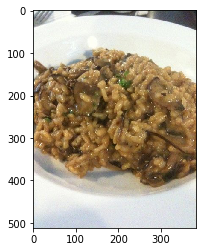

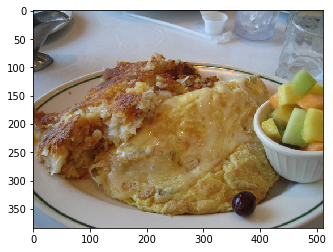

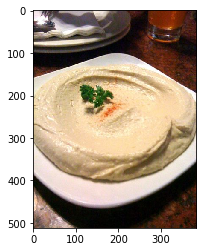

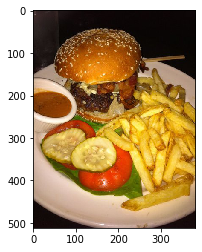

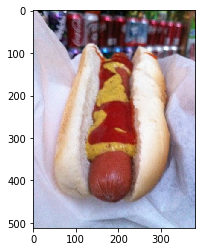

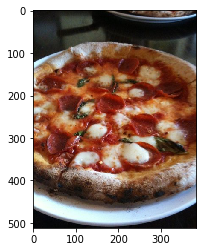

In [1]:
#example photos from dataset
import glob
import matplotlib.pyplot as plt
from PIL import Image
paths = ['./sample_photos/healthy/*.jpg', './sample_photos/unhealthy/*.jpg']
for path in paths:
    for filename in glob.glob(path):
        plt.imshow(Image.open(filename))
        plt.show()

## Transforms
- Tranformation for training - composed: Random Resized Crop (224x224), To Tensor, Normalization
- Tranformation for testing - compsed: Center Crop (224x224), To Tensor, Normalization

## Dataloader
Parameters:
- Batch size: 32
- Shuffling: ON


## Optimizer
- Type: Adam
- Learning rate: 0.001

## Model
- Idea - use pretrained model and add last custom layers.
- Model: pretrained ResNet34 + [Linear(1000,2), log_softmax]
- Loss function: Cross Entropy


In [2]:
#Model validation
from IPython.display import clear_output
import torch
from torch.utils.data import DataLoader
from model import Net
from datamodule import DataModule

batch_size = 32
path = './checkpoints/model.pt'

all_samples = 0
counter = 0

model = Net()
model.load_state_dict(torch.load(path))
model.eval()
model.cuda()
data_module = DataModule()
data_loader = DataLoader(data_module.get_valset(), batch_size=batch_size, num_workers=4, shuffle=True)


for x in iter(data_loader):
    data, target = x
    data = data.cuda()
    with torch.no_grad():
        output = model(data)
        for i in range(batch_size):
            clear_output(wait=True)
            all_samples += 1
            if output[i][0] == max(output[i]):
                out = 0
            else:
                out = 1
            if(out == target[i].cpu().detach().numpy()):
                counter += 1
    print("checked:", all_samples)

print("acc:", counter/all_samples)

checked: 4800
acc: 0.8208333333333333


Using cache found in /home/mike/.cache/torch/hub/pytorch_vision_v0.6.0
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
Real: healthy Prediction: healthy


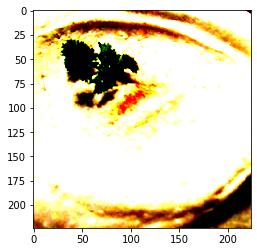

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
Real: healthy Prediction: healthy


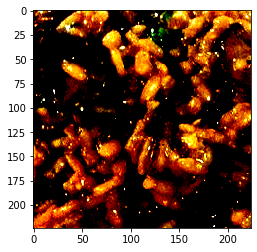

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
Real: healthy Prediction: healthy


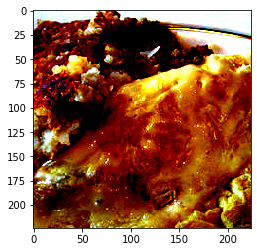

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
Real: unhealthy Prediction: unhealthy


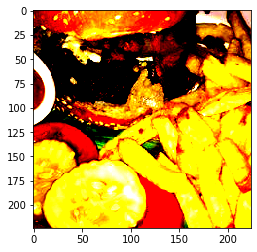

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
Real: unhealthy Prediction: unhealthy


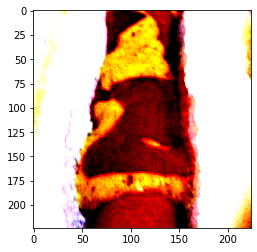

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
Real: unhealthy Prediction: unhealthy


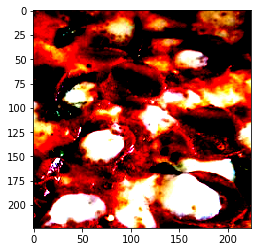

In [3]:
#simple classifier
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from model import Net
from datamodule import DataModule
from torchvision import datasets, transforms

#params
img_path = './sample_photos'
model_path = './checkpoints/model.pt'
batch_size = 6
num_workers = 4
labels = {0:'healthy', 1:'unhealthy'}

#validation transform
transform = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                            [0.229, 0.224, 0.225])
])

#dataloader
dataset = datasets.ImageFolder(img_path, transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers)

#model
model = Net()
model.load_state_dict(torch.load(model_path))
model.eval()
model.cuda()

data, target = next(iter(data_loader))
data = data.cuda()
with torch.no_grad():
    out = model(data)
    for i in range(batch_size):
        print(i)
        pred_list = out[i].cpu().tolist()
        pred = pred_list.index(max(pred_list))
        print('Real:', labels[int(target[i].numpy())], "Prediction:", labels[pred])
        plt.imshow(data[i].cpu().permute(1,2,0).numpy())
        plt.show()
        

## Summary
### Models and trainigs:
I tried using DenseNet and ResNet for current problem. ResNet occured to be better choice. I used pretrained model and added one more layer with log_softmax activation function. Whole model was trained through 5 epochs, and last layer through 30 epochs.
### Problems: 
- Adding more custom layers e.g. 1000->800->400->200->100->2 returned worse results than only one layer. Probable solution to this problem might be using better sizes, train more epochs or use better types of layers (e.g. Conv2d). 
- Training more epochs returnd worse results on validation set. This problem didn't occur only on ResNet34, but also on ResNet51 (after more epochs). Tests on training set got better results every time, so this seems to be overfitting problem. The best solution would be getting bigger dataset.